<a href="https://colab.research.google.com/github/leonardoLavagna/Drug-repurposing/blob/main/BI_LeoL_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

Before anything else remeber to:


1.   When using Google Colab collect all the needed files inside the folder BI-Data in your Google Drive.
2.   When using colab upload the auxiliary functions in the 'content' directory.



In [24]:
# ASSIGN colab = True WHEN USING GOOGLE COLAB

import os
colab=True
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/BI-Data/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!git clone https://github.com/dinaghiassian/DIAMOnD DiaBLE
!git clone https://github.com/dinaghiassian/DIAMOnD

Cloning into 'DiaBLE'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (64/64), done.
Cloning into 'DIAMOnD'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (64/64), done.


In [11]:
#https://github.com/GuyAllard/markov_clustering
%pip install markov_clustering 
%pip install networkx --upgrade
%pip install scipy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [25]:
# DIRECTORY TREE
# Change according to your file system
# This path should be the same used in the auxiliary_funtions module
# Remark . When using Google Colab remember that the path as been changed to 
# /content/drive/MyDrive/BI-Data/ 

path = './'

### Libraries

In [15]:
import re
import csv
import random
import json
import ast
import sys
import statistics
import auxiliary_functions as AF
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import markov_clustering as mc
from tqdm import tqdm
from scipy.stats import hypergeom
from sklearn.model_selection import train_test_split

## TASK 1 . PPI and GDA data gathering and interactome reconstruction

### Data gathering and interactome reconstruction

In [26]:
# DATA GATHERING AND PROCESSING

HSN = AF.interactome_processing(path+"BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")
DGA = AF.DGA_processing(path+'curated_gene_disease_associations.tsv', 'Hypertensive disease')
DG_in_PPI,splits = AF.make_seeds_splits(DGA,HSN,'Hypertensive disease',path)
DG_in_PPI, splits = AF.import_seeds_split('Hypertensive disease')

Processing interactome...


<ipython-input-26-e80c7f04d276>:3: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  HSN = AF.interactome_processing(path+"BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")


# Process completed.
Creating seed gene splits...
Number of genes in disease PPI:  290
# Process completed.
Importing seed genes...
# Process completed.


### Compute the disease LCC and its basic network measures

In [27]:
# LCC COMPUTATION

LCC = AF.extract_LCC_form_PPI(HSN)
n_nodes = LCC.number_of_nodes()

Extracting LCC...
Nodes  19618 , Connections  665061
# Process completed.


Creating Disease LCC graph...
Nodes in disease LCC  232
# Process completed.


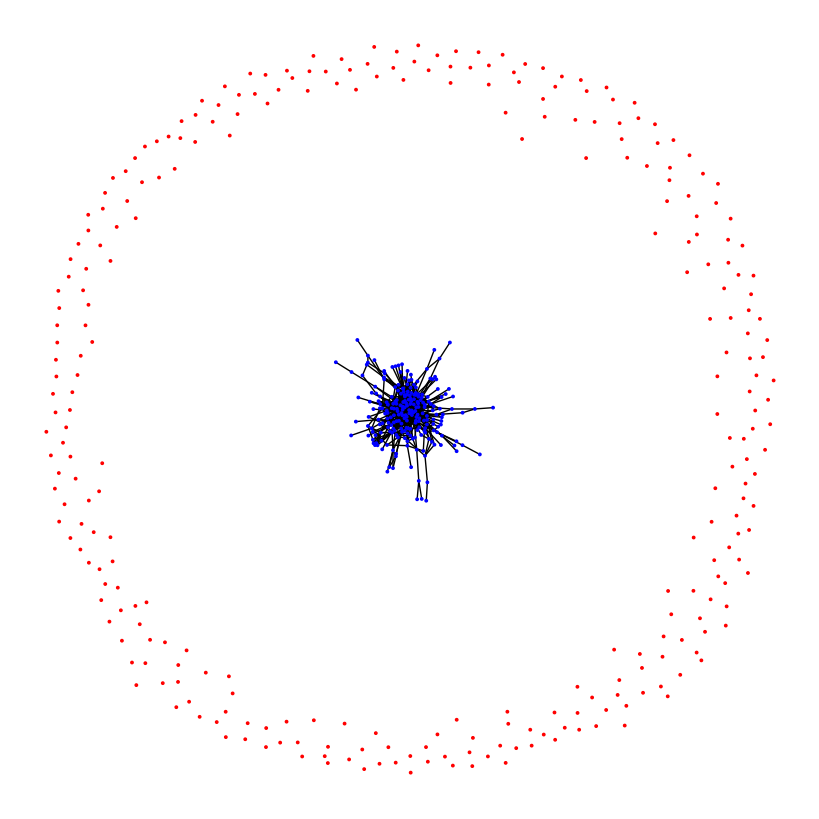

In [ ]:
# LCC PLOT

DN = AF.make_disease_graph(HSN, DGA, DG_in_PPI)
AF.plot_LCC(DN, DG_in_PPI)

In [28]:
# LOCAL MEASURES
# This cell takes a while to run...

nx.set_node_attributes(LCC, LCC.degree(), 'Node degree')  
#nx.set_node_attributes(LCC, nx.betweenness_centrality(LCC), "Betweenness centrality")
nx.set_node_attributes(LCC, nx.eigenvector_centrality(LCC), "Eigenvector centrality")
#nx.set_node_attributes(LCC, nx.closeness_centrality(LCC), "Closeness centrality")

local_measures = pd.DataFrame(index=LCC.nodes())
local_measures['Node degree'] = [d for n, d in LCC.degree()] 
#local_measures['Betweenness centrality'] = pd.Series(nx.get_node_attributes(LCC, 'Betweenness centrality'))
local_measures['Eigenvector centrality'] = pd.Series(nx.get_node_attributes(LCC, 'Eigenvector centrality'))
#local_measures['Closeness centrality'] = pd.Series(nx.get_node_attributes(LCC, 'Closeness centrality'))
#local_measures['Betweenness/Degree Ratio'] = local_measures['Betweenness centrality']/local_measures['Node degree']
local_measures.index.name='Gene'

In [29]:
# TABLE OF LOCAL MEASURES

local_measures.to_csv('local_measures.csv', index = True, header = True)
local_measures = pd.read_csv(path+'local_measures.csv', sep=',')
local_measures.head()

,Gene,Node degree,Eigenvector centrality
0,MAP2K4,51,0.002493
1,MYPN,27,0.001812
2,ACVR1,54,0.001348
3,GATA2,58,0.002803
4,RPA2,546,0.032289


## Task 2 . Putative disease genes identification algorithms

### DIAMOnD algorithm

In [30]:
## AUXILIARY FUNCTIONS TO PUT IN FILE

def diamond(LCC, seeds, splits, i, top_n, path):
    # filtering the splits at i-th iteration
    filteredSymbolGenes_ID = DGA[DGA.geneSymbol.isin(splits[str(i)])].geneId.tolist()
    actualDt = list(set(seeds) - set(filteredSymbolGenes_ID))

    textfile = open("seed_gene.txt", "w")
    for element in actualDt:
      textfile.write(str(element) + '\n')
    textfile.close()
    
    pairs_genes = list(LCC.edges)
    textfile = open("PPI_Hypertensive.txt", "w")
    for gA, gB in tqdm(pairs_genes):
        textfile.write(str(gA) + ',' + str(gB) + '\n') 
    textfile.close()
    
    !python3  DIAMOnD.py  PPI_Hypertensive.txt  seed_gene.txt  top_n 
    !mv first_200_added_nodes_weight_1.txt str(f'first_200_added_nodes_weight_1_Key{i}.txt')
    
    for x in [1000,500,250,100]: ## <<<<--------------------------------------------------------------------------
        print(x, evaluation(x, cval = len(splits['0']), alg_name = 'DIAMOnD'))
    print('\n')
    
    !mv str(f'first_200_added_nodes_weight_1_Key{i}.txt') str('./path/')

In [39]:
# EXECUTE DIAMOND
# Remark . The output file is saved in the current directory. 
# That is in '/content/drive/MyDrive/BI-Data/'

!python3  DIAMOnD.py  PPI_Hypertensive.txt  seed_gene.txt  200


 results have been saved to 'first_200_added_nodes_weight_1.txt' 



### DiaBLE algorithm

In [ ]:
# DIABLE
# Change the code in the DIAMOnD script in the DiaBLE Folder (see below) 
# then apply the diamond function with this updated file

"""
AFTER LINE 317 ADD

  candidates = set(cluster_nodes)
  universe = set()

  for _ in range(0, 2):
    for gene in candidates.copy():
      universe |= neighbors[gene]
    candidates = universe        
  
  N = len(universe)
  
"""

### Diffusion Based Algorithm

In [ ]:
#..... ??

### Validation

In [ ]:
## AUXILIARY FUNCTIONS TO PUT IN FILE

def cross_vaidation(splits,nodes,DG_in_PPI,clusters,DGA_filt,n_size=n_nodes):
    print("Executing cross validation...")
    recall = {'std_valid':[],'ext_valid':[]}
    prec =  {'std_valid':[],'ext_valid':[]}
    f1 =  {'std_valid':[],'ext_valid':[]}
    enriched_clusters = 0
    for idx in range(0,5):
        test = set(splits[str(idx)])
        training = set(DG_in_PPI).difference(test)
        positives = set()
        for cluster in clusters:
            N = n_size
            K = len(training)
            n = len(cluster)
            k = len(set(nodes[list(cluster)]).intersection(training))+10e-10
            pval = hypergeom.sf(k=k-1, M=N, n=K, N=n)
            if pval < 0.05:
                enriched_clusters += 1
                positives = positives.union(set(nodes[list(cluster)]))
        TP = test.intersection(positives)
        FP = positives.difference(test)
        FN = test.difference(positives)
        r,p,f = metrics(TP,FP,FN)
        R,P,F = metrics(FP.intersection(DGA_filt), FP.difference(DGA_filt), DGA_filt.difference(TP.union(FN)))
        recall['std_valid'] += [r]
        prec['std_valid'] += [p]
        f1['std_valid'] += [f]
        recall['ext_valid'] += [R]
        prec['ext_valid'] += [P]
        f1['ext_valid'] += [F]
     
    print('Enriched Clusters:',enriched_clusters/5)
    print("# Process completed.")
    return recall,prec,f1
    

def metrics(TP,FP,FN):
    print("Calculating matricses...")
    recall = len(TP)/(len(TP)+len(FP)+10e-10)
    prec = len(TP)/(len(TP)+len(FN)+10e-10)
    f1 = 2*(recall/5*prec/5)/(prec/5+recall/5+10e-10)
    print("# Process completed.")
    return recall, prec, f1

#### Cross-Validation splits

In [ ]:
# SET UP

with open(path+'Hypertensive disease_splits.json') as f:
  dict_ = json.load(f)

with open(path+'Hypertensive disease_seed_gene.txt') as f:
  seeds = pd.read_csv(f,sep='\t',header=None)

gene_dis_association = pd.read_csv(path+'curated_gene_disease_associations.tsv', sep = '\t')
gene_dis_association = gene_dis_association[gene_dis_association['diseaseName'] == 'Hypertensive disease']

seeds=seeds[0].to_numpy()
#seeds

In [ ]:
# CROSS VALIDATION SPLITS INTO FILES

for k,v in dict_.items():
    print(k,v)
    ids=gene_dis_association.loc[gene_dis_association.geneSymbol.isin(v)].geneId.tolist()
    l=list(set(seeds).difference(set(ids)))
    with open(path+'cross_{}.txt'.format(k),'w') as f:
        for item in l:
            f.write("%s\n" % item)
    

0 ['GSTA5', 'TRNE', 'CELA2A', 'IFT27', 'ECE1', 'EDNRA', 'AQP1', 'PPP1R3A', 'MYH11', 'SOD2', 'TRPC5', 'LDLR', 'SMAD3', 'GCH1', 'PPBP', 'USP8', 'JUN', 'CD2AP', 'ATP2B3', 'BMPR2', 'NOS3', 'MAFB', 'TGFB1', 'WNK4', 'TRNV', 'VAV3', 'ACT', 'PDE3A', 'STK11', 'STK39', 'SOD1', 'TRPC3', 'ACVRL1', 'NPPB', 'AR', 'TGFB3', 'TGM2', 'SMARCAL1', 'MFAP5', 'TRIM32', 'TRH', 'COL3A1', 'KCNMB1', 'CYTB', 'DRD2', 'ALAD', 'CRP', 'NME1', 'F12', 'VCAM1', 'GSTT2', 'GJA5', 'B2M', 'VDR', 'UMOD', 'GNRH1', 'AOC1', 'SLC12A3']
1 ['PLIN1', 'CCL2', 'VWF', 'CACNA1C', 'GPX1', 'FGA', 'TP53', 'CYBB', 'FMO3', 'GUCY1A3', 'CETP', 'PAX2', 'POMC', 'CYP1A1', 'COL4A4', 'ATP1A1', 'NF1', 'OFD1', 'LEPR', 'ERAP1', 'IFT172', 'SDCCAG8', 'ND1', 'GCG', 'ACE', 'PLAT', 'GSK3B', 'OXT', 'COX2', 'CUL3', 'CYP21A2', 'CLCNKA', 'COL1A1', 'AGT', 'MYLK', 'SMAD4', 'KCNJ1', 'NOS2', 'GLP1R', 'ATOX1', 'PROC', 'LDLRAP1', 'GNB3', 'RGS5', 'HMBS', 'SLC12A2', 'AIP', 'ADRA2A', 'MMP9', 'IQCB1', 'LEP', 'BBS1', 'ACTA2', 'CTGF', 'HMOX1', 'LMNA', 'ADCY5', 'IER3']
2 

#### Evaluation of performances

In [31]:
# CHECK

#print(splits)

{'0': ['NEDD4L', 'ITGA8', 'KLK1', 'SMAD3', 'COX3', 'NOS2', 'SMAD4', 'NPPA', 'CPOX', 'AR', 'ADD1', 'VAV3', 'BDKRB2', 'UCN', 'NPTN', 'FGFR2', 'ATP2B1', 'ELN', 'BBS2', 'KCNMB1', 'CELA2A', 'MTOR', 'BCL2', 'SOD2', 'LOX', 'CYTB', 'FN1', 'CACNA2D1', 'PDE8B', 'CMA1', 'GCG', 'GSK3B', 'PLAT', 'WT1', 'KLHL3', 'CD36', 'G6PC', 'TIMP1', 'GJA1', 'PTEN', 'HRH3', 'GNB3', 'FBN1', 'CEP164', 'ALOX15', 'HP', 'CALCA', 'ADRA2A', 'NPR1', 'TACR1', 'TRNE', 'MUC1', 'ATP2B3', 'WNK1', 'INVS', 'ITM2B', 'AOC1', 'PPARG'], '1': ['APOA1', 'SLC37A4', 'KCNJ1', 'PDE3A', 'HIF1A', 'PRKG1', 'UMOD', 'ABCB6', 'PTH', 'ACTA2', 'MKS1', 'POMC', 'GLA', 'IDUA', 'TRH', 'INS', 'ACE', 'F12', 'RPS6KB1', 'GAL', 'AIP', 'TGFB3', 'IER3', 'SOD1', 'NME1', 'IL6', 'NR3C2', 'NPPB', 'TGM2', 'SCNN1A', 'STK11', 'ND5', 'PPP1R3A', 'GSTT1', 'TLR4', 'SMARCAL1', 'FOXE3', 'ENPP1', 'CYP21A2', 'KNG1', 'MYD88', 'HSD11B1', 'MC2R', 'TRPC3', 'MAFB', 'PRKCD', 'ZMPSTE24', 'OLR1', 'AQP1', 'CRHR2', 'GUCY1A3', 'GJA5', 'PLIN1', 'LEP', 'AHR', 'RELA', 'NCF1', 'TGFB1']

In [32]:
# DICTIONARY WITH MAPPING GeneSymbol-->GeneId

geneDiseaseIDs = {
    '0': DGA[DGA.geneSymbol.isin(splits['0'])].geneId.tolist(),
    '1': DGA[DGA.geneSymbol.isin(splits['1'])].geneId.tolist(),
    '2': DGA[DGA.geneSymbol.isin(splits['2'])].geneId.tolist(),
    '3': DGA[DGA.geneSymbol.isin(splits['3'])].geneId.tolist(),
    '4': DGA[DGA.geneSymbol.isin(splits['4'])].geneId.tolist()
}

In [ ]:
# CHECK

#geneDiseaseIDs

In [40]:
## AUXILIARY FUNCTIONS TO PUT IN FILE

def evaluation(top_n, cval, alg_name):
    recalls, precs, f1s, ndcg_scores = ([] for _ in range(4))

    cv = pd.read_csv(f'first_200_added_nodes_weight_1.txt',sep='\t')
    cv_nodes = cv[alg_name + '_node'].tolist()

    # Subsetting
    top = set(cv_nodes[0:top_n]) 
    
    # Intersecting with the probe set  
    inters = top.intersection(geneDiseaseIDs[str(i)]) 

    # Appending the results
    recall = round(len(inters)/cval, 3)
    prec = round(len(inters)/top_n, 3)
    recalls.append(recall)
    precs.append(prec)

    try:
      f1s.append(round(2*((recall*prec)/(recall+prec)), 3))
    except:
      f1s.append(0)

    return {'recall': recalls, 
            'precision': precs, 
            'F1 Score': f1s, }

In [41]:
# DIAMOND 

for i in range(0, 5):
    diamond(LCC, DG_in_PPI, splits, i, top_n = 200, path = 'DIAMOnD_results')


100%|██████████| 665061/665061 [00:00<00:00, 719402.11it/s]


python3: can't open file 'DIAMOnD/DIAMOnD.py': [Errno 2] No such file or directory
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv first_200_added_nodes_weight_1.txt str(f'first_200_added_nodes_weight_1_Key0.txt')'
1000 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
500 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
250 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
100 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}


/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv str(f'first_200_added_nodes_weight_1_Key0.txt') str('./path/')'


100%|██████████| 665061/665061 [00:00<00:00, 1199734.55it/s]


python3: can't open file 'DIAMOnD/DIAMOnD.py': [Errno 2] No such file or directory
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv first_200_added_nodes_weight_1.txt str(f'first_200_added_nodes_weight_1_Key1.txt')'
1000 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
500 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
250 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
100 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}


/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv str(f'first_200_added_nodes_weight_1_Key1.txt') str('./path/')'


100%|██████████| 665061/665061 [00:00<00:00, 1181780.67it/s]


python3: can't open file 'DIAMOnD/DIAMOnD.py': [Errno 2] No such file or directory
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv first_200_added_nodes_weight_1.txt str(f'first_200_added_nodes_weight_1_Key2.txt')'
1000 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
500 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
250 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
100 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}


/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv str(f'first_200_added_nodes_weight_1_Key2.txt') str('./path/')'


100%|██████████| 665061/665061 [00:00<00:00, 1212248.75it/s]


python3: can't open file 'DIAMOnD/DIAMOnD.py': [Errno 2] No such file or directory
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv first_200_added_nodes_weight_1.txt str(f'first_200_added_nodes_weight_1_Key3.txt')'
1000 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
500 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
250 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
100 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}


/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv str(f'first_200_added_nodes_weight_1_Key3.txt') str('./path/')'


100%|██████████| 665061/665061 [00:00<00:00, 1175690.02it/s]


python3: can't open file 'DIAMOnD/DIAMOnD.py': [Errno 2] No such file or directory
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv first_200_added_nodes_weight_1.txt str(f'first_200_added_nodes_weight_1_Key4.txt')'
1000 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
500 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
250 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}
100 {'recall': [0.0], 'precision': [0.0], 'F1 Score': [0]}


/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mv str(f'first_200_added_nodes_weight_1_Key4.txt') str('./path/')'


In [ ]:
# DIABLE

for i in range(0, 5):
    diamond(LCC, DG_in_PPI, splits, i, top_n = 1000, path = '...')###<-------------------------

In [ ]:
# DIFFUSION BASED

#... ?

## Optional Task 3 MCL

In [ ]:
# SET UP

curated_gene_desease_association_DF = pd.read_csv("/content/curated_gene_disease_associations.tsv", sep = '\t', compression = 'infer')
disease_DF = curated_gene_desease_association_DF.loc[curated_gene_desease_association_DF['diseaseId'] == 'C0020538']

In [ ]:
# SEED GENES

seed_list = list(disease_DF['geneId'])
seed_genes_symbols = list(disease_DF['geneSymbol'])

In [ ]:
# CLUSTERS

result = mc.run_mcl(nx.to_scipy_sparse_matrix(G))           
clusters = mc.get_clusters(result) 

In [ ]:
# PLOT

mc.draw_graph(nx.to_scipy_sparse_matrix(G), clusters, node_size=10, with_labels=False, edge_color="silver")

In [ ]:
# PERFORM CLUSTERING
# Use different inflation values from 1.5 and 2.5
# for each clustering run calculate the modularity

matrix = nx.to_scipy_sparse_matrix(G)
for inflation in [i / 10 for i in range(15, 26)]:
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

Now that we have found the clusters, we filter them in order to keep only those having at least 10 nodes and in which the seed genes are statistically overrepresented. The resulting sets are the putative desease modules.

In [ ]:
# KEEP CLUSTERS WITH AT LEAST 10 GENES

big_clusters = []
for module in clusters:
    if len(module) >= 10:
        big_clusters.append(module)
print(len(clusters), len(big_clusters))

In [ ]:
# DICTIONARY WITH MAPPING {nodeID : gene name}

val = range(G.number_of_nodes())
names = list(G.nodes())
dic = dict(zip(val, names))

In [ ]:
# RUN THE HYPERGEOMETRIC TEST TO FIND MODULES WITH STATISTICALLY OVERREPRESENTED SEED GENES

putative_desease_modules = []
M = G.number_of_nodes() # population size (total number of genes) 
n = len(seed_genes_symbols) # number of seed genes
p_val_list = []
for module in big_clusters:
    N = len(module) # number of draws (number of genes in the given cluster)
    x = len(set(seed_genes_symbols).intersection(set(dic[g] for g in module)))
    p_val = hypergeom.sf(x-1, M, n, N)
    if p_val < 0.05:
        putative_desease_modules.append(module)
        p_val_list.append(p_val)

In [ ]:
# PUTATIVE DISEASE MODULES TO PUT IN THE FOLLOWING DATAFRAME

for i in range(len(putative_desease_modules)):
    print("Desease putative module ",i, ": ", *[dic[g] for g in putative_desease_modules[i]])

In [ ]:
# DATAFRAME OF PUTATIVE DISEASE MODULES

header = ['ModuleID', "Number of seed genes/module", "Module size", "Seed genes", "All genes", "p-value"]
df_putative_desease_modules = pd.DataFrame(columns=header)
for i in range(len(putative_desease_modules)):
    seeds = set(seed_genes_symbols).intersection(set(dic[g] for g in putative_desease_modules[i]))
    values = [i, len(seeds), len(putative_desease_modules[i]), seeds, [dic[g] for g in putative_desease_modules[i]],p_val_list[i]]
    df = pd.DataFrame( [values], columns = header)
    df_putative_desease_modules = df_putative_desease_modules.append(df, ignore_index=True)

In [ ]:
# CHECK

df_putative_desease_modules